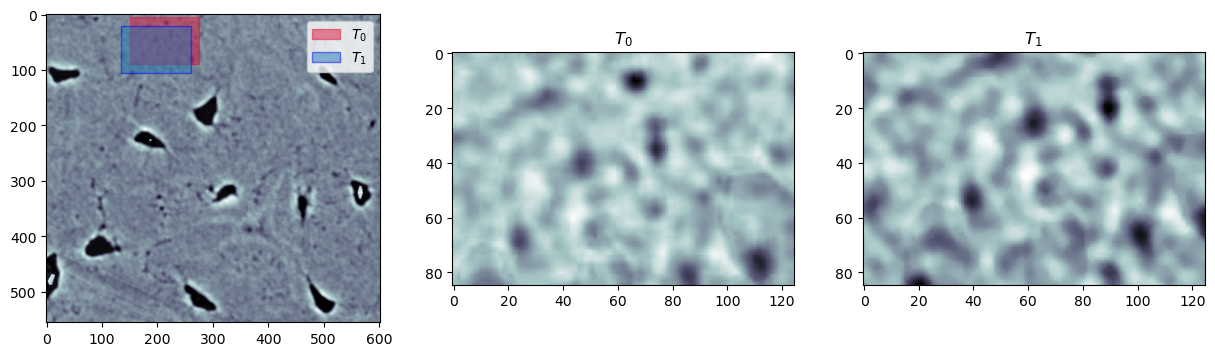

In [58]:
import numpy as np
from skimage.filters import median
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread
from tqdm import tqdm
%matplotlib inline
full_img = imread("figures/bonegfiltslice.png")[:,:,0:3].mean(axis=2)
full_shift_img = median(
    np.roll(np.roll(full_img, -15, axis=0), 15, axis=1), footprint=np.ones((3, 3)))

def g_roi(x): return x[5:90, 150:275]

bw_img = g_roi(full_img)
shift_img = g_roi(full_shift_img)

fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.imshow(full_img,cmap='bone')
r=Rectangle((150,5),125,85,ec='crimson',fc='crimson',alpha=0.5,label=r"$T_0$")
ax0.add_patch(r)
r=Rectangle((135,20),125,85,ec='blue',alpha=0.5,label=r"$T_1$")
ax0.add_patch(r)
ax0.legend()
ax1.imshow(bw_img, cmap='bone')
ax1.set_title('$T_0$')
ax2.imshow(shift_img, cmap='bone')
ax2.set_title('$T_1$');

# SimpleElastix

In [73]:
import SimpleITK as sitk
import numpy as np

# Convert the NumPy arrays to SimpleITK images
fixed_image_sitk = sitk.GetImageFromArray(bw_img)
moving_image_sitk = sitk.GetImageFromArray(shift_img)

# Initialize the SimpleElastix image registration object
# registration = sitk.ElastixImageFilter()
registration = sitk.SimpleElastix()


# Set the fixed and moving images
registration.SetFixedImage(fixed_image_sitk)
registration.SetMovingImage(moving_image_sitk)

# Set the parameter map for the registration
parameter_map = sitk.GetDefaultParameterMap('affine')
registration.SetParameterMap(parameter_map)

# Perform the image registration
registration.Execute()

# Get the registered image as a NumPy array
registered_image = sitk.GetArrayFromImage(registration.GetResultImage())


_, ax = plt.subplots(1,3,figsize=(15,4))

ax=ax.ravel()

for axs,img in zip(ax,[bw_img,shift_img,image1_warp]) :
    axs.imshow(img)

AttributeError: module 'SimpleITK' has no attribute 'SimpleElastix'

In [75]:
sitk.

Help on package SimpleITK:

NAME
    SimpleITK

DESCRIPTION
    # ========================================================================
    #
    #  Copyright NumFOCUS
    #
    #  Licensed under the Apache License, Version 2.0 (the "License");
    #  you may not use this file except in compliance with the License.
    #  You may obtain a copy of the License at
    #
    #         http://www.apache.org/licenses/LICENSE-2.0.txt
    #
    #  Unless required by applicable law or agreed to in writing, software
    #  distributed under the License is distributed on an "AS IS" BASIS,
    #  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    #  See the License for the specific language governing permissions and
    #  limitations under the License.
    #
    # ========================================================================

PACKAGE CONTENTS
    SimpleITK
    _SimpleITK
    _version
    extra

DATA
    SITK_ITK_VERSION_MAJOR = 5
    SITK_ITK_VERSION_MINOR 

# SciKit Image

In [31]:
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.registration import optical_flow_ilk,optical_flow_tvl1
from skimage.transform import warp
reference_image, moving_image, disp = stereo_motorcycle()
# --- Convert the images to gray level: color is not supported.
reference_image = bw_img
moving_image    = shift_img 
[u,v]= optical_flow_tvl1(moving_image, reference_image)

In [32]:
flow.shape

(2, 85, 125)

In [33]:
nr, nc = bw_img.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

image1_warp = warp(shift_img, np.array([row_coords + v, col_coords + u]),
                   mode='edge')

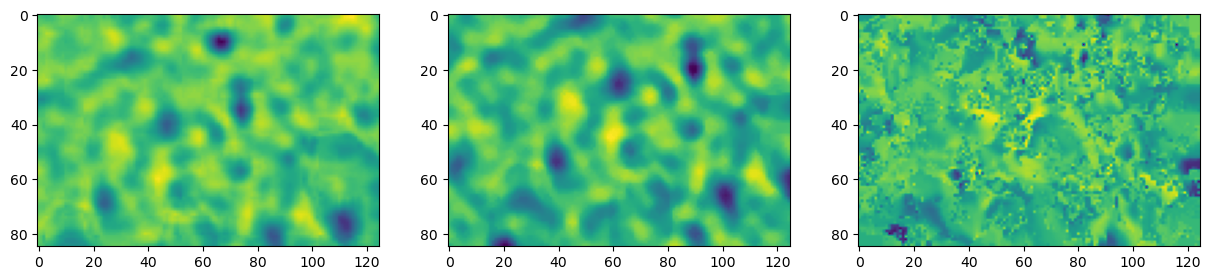

In [34]:
_, ax = plt.subplots(1,3,figsize=(15,4))

ax=ax.ravel()

for axs,img in zip(ax,[bw_img,shift_img,image1_warp]) :
    axs.imshow(img)

# Tensorflow version

In [179]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate a random image to use as the fixed image
fixed_image = np.random.rand(256, 256)

# Generate a random transformation to apply to the moving image
theta = np.pi/4
tx = 30
ty = -20
cos_t = np.cos(theta)
sin_t = np.sin(theta)
moving_image = np.zeros_like(fixed_image)
for i in range(fixed_image.shape[0]):
    for j in range(fixed_image.shape[1]):
        x = cos_t*(i-fixed_image.shape[0]/2) - sin_t*(j-fixed_image.shape[1]/2) + tx + fixed_image.shape[0]/2
        y = sin_t*(i-fixed_image.shape[0]/2) + cos_t*(j-fixed_image.shape[1]/2) + ty + fixed_image.shape[1]/2
        if x >= 0 and x < fixed_image.shape[0] and y >= 0 and y < fixed_image.shape[1]:
            moving_image[i, j] = fixed_image[int(np.floor(x)), int(np.floor(y))]

# Define the TensorFlow 2 graph
tf.compat.v1.disable_eager_execution()
graph = tf.Graph()
with graph.as_default():
    # Define the fixed and moving images as placeholders
    fixed_image_ph = tf.compat.v1.placeholder(tf.float32, shape=(None, None))
    moving_image_ph = tf.compat.v1.placeholder(tf.float32, shape=(None, None))

    # Define the transformation parameters as variables
    theta_var = tf.Variable(0.0, dtype=tf.float32)
    tx_var = tf.Variable(0.0, dtype=tf.float32)
    ty_var = tf.Variable(0.0, dtype=tf.float32)

    # Define the transformation matrix
    cos_t = tf.cos(theta_var)
    sin_t = tf.sin(theta_var)
    mat = tf.constant([[cos_t, -sin_t, tx_var], [sin_t, cos_t, ty_var], [0, 0, 1]])

    # Apply the transformation to the moving image
    transformed_image = tf.compat.v1.contrib.image.transform(moving_image_ph, mat, interpolation='BILINEAR')

    # Define the loss as the mean squared difference between the fixed and transformed moving images
    loss = tf.reduce_mean(tf.square(fixed_image_ph - transformed_image))

    # Define the optimizer
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

# Run the TensorFlow 2 graph to perform the image registration
with tf.compat.v1.Session(graph=graph) as sess:
    # Initialize the variables
    sess.run(tf.compat.v1.global_variables_initializer())

    # Perform the optimization
    for i in range(100):
        _, loss_val = sess.run([optimizer, loss], feed_dict={fixed_image_ph: fixed_image, moving_image_ph: moving_image})
        if i % 10 == 0:
            print('Iteration {}: Loss = {}'.format(i, loss_val))

    # Get the registered image
    registered_image = sess.run(transformed_image, feed_dict={moving_image_ph: moving_image,
                                                              theta_var: sess.run(theta_var),
                                                              tx_var: sess.run(tx_var),
                                                              ty_var: sess.run(ty_var)})

# Plot the results
plt.subplot(1, 3, 1)
plt.imshow(fixed_image, cmap='gray')
plt.title('Fixed image')
plt.axis('off')



TypeError: Expected any non-tensor type, but got a tensor instead.

# Tensorflow 2.0 style 2023

In [60]:
# Load the fixed and moving images

import tensorflow as tf
from tensorflow.keras.preprocessing.image import apply_affine_transform

fixed_image  = tf.keras.preprocessing.image.load_img('figures/bonegfiltslice.png')
moving_image = tf.keras.preprocessing.image.load_img('figures/bonegfiltslice.png')
print(fixed_image)
# Convert the images to tensors
# fixed_image  = tf.keras.preprocessing.image.img_to_array(fixed_image)
# moving_image = tf.keras.preprocessing.image.img_to_array(moving_image)
# fixed_image  = tf.keras.preprocessing.image.img_to_array(bw_img)
# moving_image = tf.keras.preprocessing.image.img_to_array(shift_img)
fixed_image  = tf.convert_to_tensor(bw_img)
moving_image = tf.convert_to_tensor(shift_img)


# Normalize the images
fixed_image  = fixed_image  / 255.0
moving_image = moving_image / 255.0

<PIL.Image.Image image mode=RGB size=602x556 at 0x3338543D0>


In [61]:
# original GPT version
import tensorflow as tf

def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    cos_theta  = tf.math.cos(transform_params.numpy()[0])
    sin_theta  = tf.math.sin(transform_params[0])
    tx         = transform_params[1]
    ty         = transform_params[2]
    affine_mat = tf.reshape(tf.stack([cos_theta, -sin_theta, tx,
                                      sin_theta, cos_theta, ty]), (2, 3))

    # Apply affine transform to moving image
    batch_size = tf.shape(moving_img)[0]
    height     = tf.shape(moving_img)[1]
    width      = tf.shape(moving_img)[2]
    channels   = tf.shape(moving_img)[3]
    
    print(batch_size,height,width,channels)

    # Reshape image to 2D tensor and append ones for affine transform
    N = height * width * channels
    flat_img       = tf.reshape(moving_img, [batch_size,height * width * channels])
    ones           = tf.ones((batch_size, 1), dtype=tf.float32)
    
    homog_flat_img = tf.concat([flat_img, ones], axis=1)
    # Apply affine transform to homogenous coordinates
    homog_transformed = tf.matmul(homog_flat_img, tf.transpose(affine_mat))
    transformed       = tf.reshape(homog_transformed[:, :-1], [batch_size, height, width, channels])
    return transformed

def similarity_loss(fixed_img, moving_img, transform_params):
    # Apply affine transform to moving image
    transformed_img = affine_transform(fixed_img, moving_img, transform_params)
    # Compute mean squared error between fixed and transformed moving images
    mse = tf.reduce_mean(tf.square(fixed_img - transformed_img))
    return mse

In [62]:
@tf.function
def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]

    # Construct the affine transform matrix
    transform = tf.stack([
        tf.cos(theta), -tf.sin(theta), tx,
        tf.sin(theta), tf.cos(theta), ty
    ])
    transform = tf.reshape(transform, shape=(2, 3))

    # Apply the affine transform to the moving image
    

    return transformed

In [63]:
from skimage import transform as transf
import scipy.ndimage as nd

def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]
    
    mat=[cos_theta, -sin_theta, tx,
        sin_theta, cos_theta, ty]
    transformed_image = nd.affine_transform(moving_img, mat);
    
    return transformed_image

def affine_transform1(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]
    
    transformed=apply_affine_transform(moving_image,theta=theta,tx=tx,ty=ty)

    return transformed

def affine_transform_gpt(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    cos_theta  = tf.math.cos(transform_params[0])
    sin_theta  = tf.math.sin(transform_params[0])
    tx         = transform_params[1]
    ty         = transform_params[2]
    affine_mat = tf.reshape(tf.stack([cos_theta, -sin_theta, tx,
                                      sin_theta, cos_theta, ty]), (2, 3))

    # Apply affine transform to moving image
    height     = tf.shape(moving_img)[0]
    width      = tf.shape(moving_img)[1]
    
    channels   = 1
    
    print(height,width)

    # Reshape image to 2D tensor and append ones for affine transform
    N = height * width * channels
    flat_img       = tf.reshape(moving_img, [1,height * width * channels])
    ones           = tf.ones((1, 1), dtype=tf.float32)
    
    homog_flat_img = tf.concat([flat_img, ones], axis=1)
    # Apply affine transform to homogenous coordinates
    homog_transformed = tf.matmul(homog_flat_img, tf.transpose(affine_mat))
    transformed       = tf.reshape(homog_transformed[:, :-1], [1, height, width, channels])
    return transformed

from affine_op import affine_transform

def affine_transform2(fixed_img, moving_img, transform_params):
    cos_theta  = tf.math.cos(transform_params[0])
    sin_theta  = tf.math.sin(transform_params[0])
    tx         = transform_params[1]
    ty         = transform_params[2]
    affine_mat = tf.tile(tf.stack([cos_theta, -sin_theta, tx,
                                      sin_theta, cos_theta, ty]), (1,))
    
    affine_mat  = tf.reshape(affine_mat, (1, 6))
    transformed = affine_transform(moving_img, affine_mat)
    
    return transformed

def similarity_loss(fixed_img, moving_img, transform_params):
    # Apply affine transform to moving image
#     transformed_img = affine_transform1(fixed_img, moving_img, transform_params)
    transformed_img = moving_img
    
    # Compute mean squared error between fixed and transformed moving images
    mse = tf.reduce_mean(tf.square(fixed_img - transformed_img))
    
    return mse

# Define the transform parameters as trainable variables
theta = tf.Variable(0.0, dtype=tf.float32, trainable=True)
tx    = tf.Variable(0.0, dtype=tf.float32, trainable=True)
ty    = tf.Variable(0.0, dtype=tf.float32, trainable=True)
transform_params = [theta, tx, ty]

# Define the optimizer
optimizer = tf.optimizers.Adam()

# Define the training loop
for i in range(100):
    with tf.GradientTape() as tape:
        tape.watch(transform_params)
        tape.watch(moving_image)
        tape.watch(fixed_image)
        loss = similarity_loss(fixed_image, moving_image, transform_params)
        
    tf.print(transform_params)
    gradients = tape.gradient(loss, transform_params)

    print(gradients)
    optimizer.apply_gradients(zip(gradients, transform_params))
    
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.numpy()}')

# Apply the learned transform to the moving image
registered_image = affine_transform(fixed_image, moving_image, transform_params)

# Save the registered image
tf.keras.preprocessing.image.save_img('registered_image.jpg', registered_image[0])

[0, 0, 0]
[None, None, None]


ValueError: No gradients provided for any variable: (['Variable:0', 'Variable:0', 'Variable:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>), (None, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>), (None, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>)).

In [64]:
loss = similarity_loss(fixed_image, moving_image, transform_params)

print(loss)

tf.Tensor(0.0036904731965835165, shape=(), dtype=float64)


In [65]:
theta = tf.Variable(0.2, dtype=tf.float32)
tx    = tf.Variable(5.0, dtype=tf.float32)
ty    = tf.Variable(5.0, dtype=tf.float32)
transform_params = [theta, tx, ty]

registered_image = affine_transform(fixed_image, moving_image,transform_params)
_,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(moving_image)
ax[1].imshow(registered_image)
ax[2].imshow(registered_image-moving_image)

2024-04-24 20:39:23.177561: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 2 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [66]:
moving_image.shape

TensorShape([85, 125])

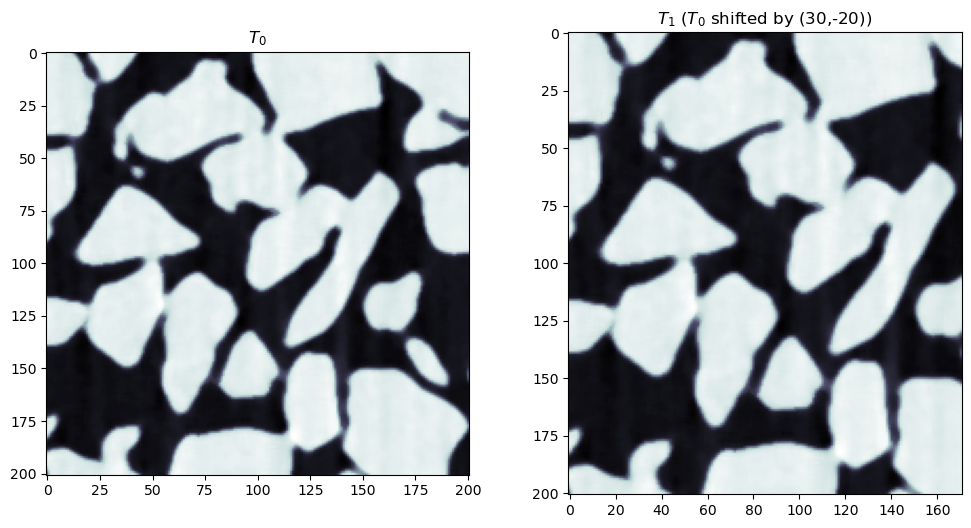

In [67]:
# Distance as feature 
bw_sand = plt.imread('data/sand.png').astype(float) # Some sand grains

shift_sand = bw_sand[:,:-30]
bw_sand = bw_sand[:shift_sand.shape[0],:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
ax1.imshow(bw_sand,cmap='bone'), ax1.set_title('$T_0$')
ax2.imshow(shift_sand, cmap='bone') , ax2.set_title('$T_1$ ($T_0$ shifted by (30,-20))');

In [68]:
from scipy.ndimage import distance_transform_edt
from skimage.filters import threshold_otsu


In [69]:
thresh_img = bw_sand > threshold_otsu(bw_sand)
dist_start_img = distance_transform_edt(thresh_img)
dist_shift_img = distance_transform_edt(shift_sand > threshold_otsu(bw_sand))

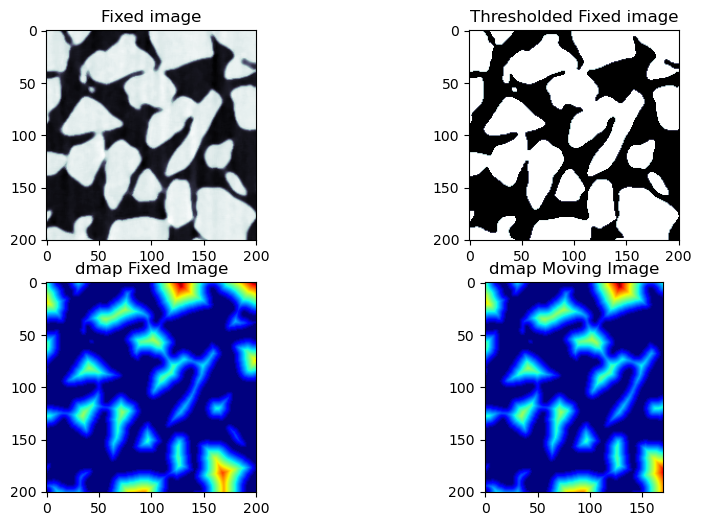

In [70]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(10,6))
ax1.imshow(bw_sand, cmap='bone')
ax1.set_title('Fixed image')
ax2.imshow(thresh_img, cmap='bone')
ax2.set_title('Thresholded Fixed image')
ax3.imshow(dist_start_img, cmap='jet')
ax3.set_title('dmap Fixed Image')
ax4.imshow(dist_shift_img, cmap='jet')
ax4.set_title('dmap Moving Image');

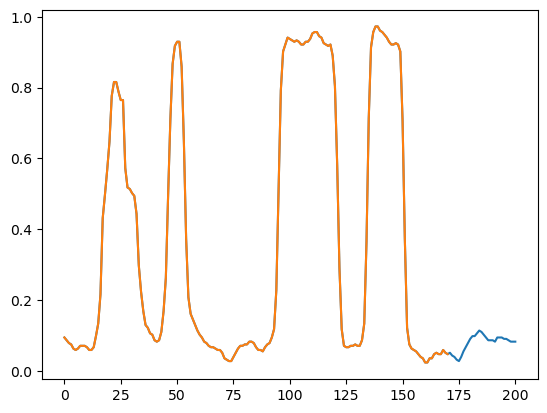

In [71]:
plt.plot(bw_sand[100])
plt.plot(shift_sand[100])

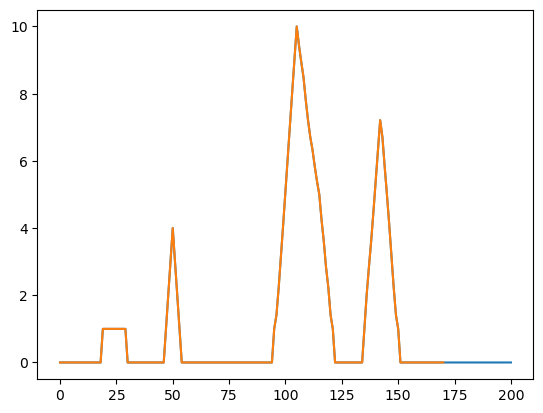

In [72]:
plt.plot(dist_start_img[100])
plt.plot(dist_shift_img[100])


# Tensorflow 2.0 style 2024

In [73]:
import tensorflow as tf

"""
Code taken from https://github.com/kevinzakka/spatial-transformer-network/blob/master/transformer.py
modified to work with tensorflow 2.0
"""

@tf.function
def affine_transform(input_fmap, theta, out_dims=None, **kwargs):
    """
    Spatial Transformer Network layer implementation as described in [1].
    The layer is composed of 3 elements:
    - localisation_net: takes the original image as input and outputs 
      the parameters of the affine transformation that should be applied
      to the input image.
    - affine_grid_generator: generates a grid of (x,y) coordinates that 
      correspond to a set of points where the input should be sampled 
      to produce the transformed output.
    - bilinear_sampler: takes as input the original image and the grid
      and produces the output image using bilinear interpolation.
    Input
    -----
    - input_fmap: output of the previous layer. Can be input if spatial
      transformer layer is at the beginning of architecture. Should be 
      a tensor of shape (B, H, W, C). 
    - theta: affine transform tensor of shape (B, 6). Permits cropping, 
      translation and isotropic scaling. Initialize to identity matrix. 
      It is the output of the localization network.
    Returns
    -------
    - out_fmap: transformed input feature map. Tensor of size (B, H, W, C).
    Notes
    -----
    [1]: 'Spatial Transformer Networks', Jaderberg et. al,
         (https://arxiv.org/abs/1506.02025)
    """
    # grab input dimensions
    B = tf.shape(input_fmap)[0]
    H = tf.shape(input_fmap)[1]
    W = tf.shape(input_fmap)[2]
    C = tf.shape(input_fmap)[3]

    # reshape theta to (B, 2, 3)
    theta = tf.reshape(theta, [B, 2, 3])

    # generate grids of same size or upsample/downsample if specified
    if out_dims:
        out_H = out_dims[0]
        out_W = out_dims[1]
        batch_grids = affine_grid_generator(out_H, out_W, theta)
    else:
        batch_grids = affine_grid_generator(H, W, theta)

    x_s = batch_grids[:, 0, :, :]
    y_s = batch_grids[:, 1, :, :]

    # sample input with grid to get output
    out_fmap = bilinear_sampler(input_fmap, x_s, y_s)

    return out_fmap

def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')
    batch_grids = tf.matmul(theta, sampling_grid)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])
    return batch_grids

def bilinear_sampler(input_fmap, x, y):
    B = tf.shape(input_fmap)[0]
    H = tf.shape(input_fmap)[1]
    W = tf.shape(input_fmap)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)
    Ia = get_pixel_value(input_fmap, x0, y0)
    Ib = get_pixel_value(input_fmap, x0, y1)
    Ic = get_pixel_value(input_fmap, x1, y0)
    Id = get_pixel_value(input_fmap, x1, y1)
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])
    return out

def get_pixel_value(img, x, y):
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]
    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))
    indices = tf.stack([b, y, x], 3)
    return tf.gather_nd(img, indices)

In [84]:
fixed_image  = tf.keras.preprocessing.image.load_img('figures/bonegfiltslice.png')
moving_image = tf.keras.preprocessing.image.load_img('figures/bonegfiltslice.png')
print(fixed_image)

fixed_image  = tf.convert_to_tensor(bw_img)
moving_image = tf.convert_to_tensor(shift_img)

fixed_image  = tf.expand_dims(fixed_image, 0)
moving_image = tf.expand_dims(moving_image, 0)
fixed_image  = tf.expand_dims(fixed_image, -1)
moving_image = tf.expand_dims(moving_image, -1)


# Normalize the images
fixed_image  = fixed_image  / 255.0
moving_image = moving_image / 255.0

fixed_image  = tf.cast(fixed_image, "float32")
moving_image = tf.cast(moving_image, "float32")

<PIL.Image.Image image mode=RGB size=602x556 at 0x35EDE43D0>


## Proposed by copilot 2024

In [75]:
import tensorflow as tf
from affine_op_tf2 import affine_transform

# tf Graph Input
# fixed_img = tf.Variable(tf.random.normal([1, 100, 100, 1]), name='FixedImage')
# moving_img = tf.Variable(tf.random.normal([1, 100, 100, 1]), name='MovingImage')

# Set transform parameters
x_offset = tf.Variable(0.0, name="x_offset")
y_offset = tf.Variable(0.0, name="y_offset")
# we keep scale and rotation fixed
scale = tf.Variable(1.0, name="scale")
rotation = tf.Variable(0.0, name="rotation")

# transformer and interpolator
flat_mat = tf.tile([tf.cos(rotation), -tf.sin(rotation), x_offset,
                    tf.sin(rotation), tf.cos(rotation), y_offset], (1,))
flat_mat = tf.cast(tf.reshape(flat_mat, (1, 6)),"float32")
trans_tensor = affine_transform(moving_image, flat_mat)

# metric
mse = tf.reduce_mean(tf.square(fixed_image-trans_tensor), name='MeanSquareError')
optimizer = tf.optimizers.SGD(1e-5)

# Training step
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        trans_tensor = affine_transform(moving_image, flat_mat)
        mse = tf.reduce_mean(tf.square(fixed_image-trans_tensor))
    gradients = tape.gradient(mse, [x_offset, y_offset])
    optimizer.apply_gradients(zip(gradients, [x_offset, y_offset]))

# Run the training step
train_step()

ValueError: in user code:

    File "/var/folders/hj/l3z3z7bj663f4wp4vlx69lt40000nw/T/ipykernel_74752/3291080597.py", line 32, in train_step  *
        optimizer.apply_gradients(zip(gradients, [x_offset, y_offset]))
    File "/Users/kaestner/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1222, in apply_gradients  **
        grads_and_vars = self.aggregate_gradients(grads_and_vars)
    File "/Users/kaestner/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1184, in aggregate_gradients
        return optimizer_utils.all_reduce_sum_gradients(grads_and_vars)
    File "/Users/kaestner/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/optimizers/utils.py", line 33, in all_reduce_sum_gradients
        filtered_grads_and_vars = filter_empty_gradients(grads_and_vars)
    File "/Users/kaestner/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/optimizers/utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['x_offset:0', 'y_offset:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'x_offset:0' shape=() dtype=float32>), (None, <tf.Variable 'y_offset:0' shape=() dtype=float32>)).


## Adapting old code by copilot

In [76]:
def similarity_loss(fixed_img, moving_img, transform_params):
    # Apply affine transform to moving image
#     transformed_img = affine_transform(fixed_img, moving_img, transform_params)
    transformed_img = affine_transform(moving_img, transform_params)
    
    # Compute mean squared error between fixed and transformed moving images
    mse = tf.reduce_mean(tf.square(fixed_img[:,10:-10,10:-10] - transformed_img[:,10:-10,10:-10]))
    
    return mse

# Define the transform parameters as trainable variables
# Set transform parameters
x_offset = tf.Variable(0.0, name="x_offset")
y_offset = tf.Variable(0.0, name="y_offset")
# we keep scale and rotation fixed
scale    = tf.Variable(1.0, name="scale")
rotation = tf.Variable(0.0, name="rotation")

# transformer and interpolator
flat_mat = tf.Variable(tf.tile([tf.cos(rotation), -tf.sin(rotation), x_offset,
                    tf.sin(rotation), tf.cos(rotation), y_offset], (1,)),dtype=tf.float32)
# flat_mat = tf.cast(tf.reshape(flat_mat, (1, 6)),"float32")


# Define the optimizer
# optimizer = tf.optimizers.Adam()
optimizer = tf.keras.optimizers.legacy.Adam()

# Define the training loop
for i in range(100):
    with tf.GradientTape() as tape:
        tape.watch(transform_params)
        tape.watch(moving_image)
        tape.watch(fixed_image)
        loss = similarity_loss(fixed_image, moving_image, flat_mat)
        
#     tf.print(loss,flat_mat)
    gradients = tape.gradient(loss, [flat_mat])

#     print(gradients)
    optimizer.apply_gradients(zip(gradients, [flat_mat]))
    
    if i % 10 == 0:
        print(f'Loss at step {i}: {loss.numpy()}')

# Apply the learned transform to the moving image
registered_image = affine_transform(fixed_image, flat_mat)

# Save the registered image
tf.keras.preprocessing.image.save_img('registered_image.jpg', registered_image[0])

Loss at step 0: 0.004029170610010624
Loss at step 10: 0.0039557660929858685
Loss at step 20: 0.003909798804670572
Loss at step 30: 0.003880781354382634
Loss at step 40: 0.003844108199700713
Loss at step 50: 0.0038128679152578115
Loss at step 60: 0.003760567167773843
Loss at step 70: 0.003694860963150859
Loss at step 80: 0.003616099478676915
Loss at step 90: 0.0035189359914511442


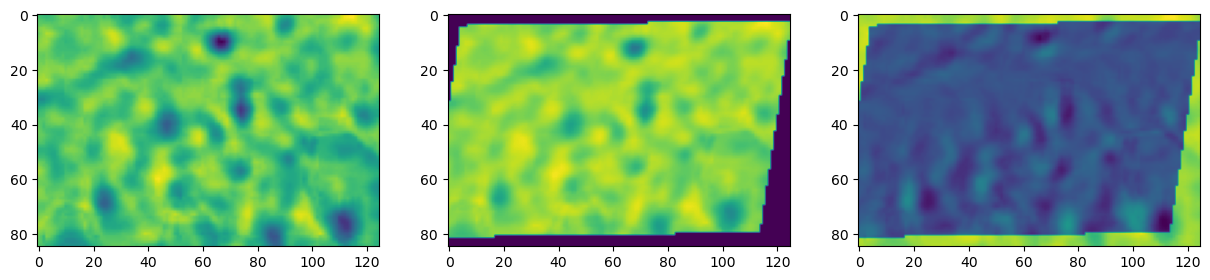

In [77]:
fig,ax =plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(fixed_image[0])
ax[1].imshow(registered_image[0])
ax[2].imshow((fixed_image-registered_image)[0])

## New try with old code translated by copilot

In [86]:
import tensorflow as tf

def affine_transform(input_fmap, theta, out_dims=None):
    """
    Spatial Transformer Network layer implementation as described in [1].
    The layer is composed of 3 elements:
    - localisation_net: takes the original image as input and outputs 
      the parameters of the affine transformation that should be applied
      to the input image.
    - affine_grid_generator: generates a grid of (x,y) coordinates that 
      correspond to a set of points where the input should be sampled 
      to produce the transformed output.
    - bilinear_sampler: takes as input the original image and the grid
      and produces the output image using bilinear interpolation.
    Input
    -----
    - input_fmap: output of the previous layer. Can be input if spatial
      transformer layer is at the beginning of architecture. Should be 
      a tensor of shape (B, H, W, C). 
    - theta: affine transform tensor of shape (B, 6). Permits cropping, 
      translation and isotropic scaling. Initialize to identity matrix. 
      It is the output of the localization network.
    Returns
    -------
    - out_fmap: transformed input feature map. Tensor of size (B, H, W, C).
    Notes
    -----
    """
    # Handle the importing for TensorFlow 1.x and 2.x
    B, H, W, C = input_fmap.shape
    theta = tf.reshape(theta, (-1, 2, 3))

    # Create a grid of coordinates
    x = tf.linspace(-1, 1, W)
    y = tf.linspace(-1, 1, H)
    x_t, y_t = tf.meshgrid(x, y)
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # Replicate the grid for each batch
    ones = tf.ones_like(x_t_flat)
    grid = tf.stack([x_t_flat, y_t_flat, ones])
    grid = tf.expand_dims(grid, 0)
    grid = tf.reshape(grid, [-1])
    grid = tf.tile(grid, tf.stack([B]))
    grid = tf.reshape(grid, (B, 3, -1))

    # Transform the grid using the parameters
    t_g = tf.matmul(theta, grid)
    x_s = tf.reshape(t_g[:, 0], [B, H, W])
    y_s = tf.reshape(t_g[:, 1], [B, H, W])
    x_s_flat = tf.reshape(x_s, [-1])
    y_s_flat = tf.reshape(y_s, [-1])

    # Rescale coordinates from [-1, 1] to [0, width/height]
    x = tf.cast(W, tf.float32) * (x_s_flat + 1.0) / 2.0
    y = tf.cast(H, tf.float32) * (y_s_flat + 1.0) / 2.0

    # Perform bilinear sampling
    input_transformed = tf.compat.v1.image.resize_bilinear(input_fmap, [H, W])

    return input_transformed


# Set transform parameters
x_offset = tf.Variable(0.0, name="x_offset")
y_offset = tf.Variable(0.0, name="y_offset")

# we keep scale and rotation fixed
scale = tf.constant(1.0, name="scale")
rotation = tf.constant(0.0, name="rotation")

@tf.function
def transform_images(fixed_img, moving_img):
    with tf.name_scope('transformer_and_interpolator'):
        flat_mat = tf.tile([tf.cos(rotation), -tf.sin(rotation), x_offset,
                            tf.sin(rotation), tf.cos(rotation), y_offset], (1,))
        flat_mat = tf.reshape(flat_mat, (1, 6))
        trans_tensor = affine_transform(moving_img, flat_mat)

    with tf.name_scope('metric'): 
        mse = tf.reduce_mean(
            tf.square(fixed_img-trans_tensor), name='MeanSquareError')
        return mse

optimizer = tf.optimizers.SGD(1e-5)

@tf.function
def train_step(fixed_img, moving_img):
    with tf.GradientTape() as tape:
        loss = transform_images(fixed_img, moving_img)
    gradients = tape.gradient(loss, [x_offset, y_offset])
    optimizer.apply_gradients(zip(gradients, [x_offset, y_offset]))
    return loss

def make_feed_dict(f_img, m_img):
    return {'fixed_img': np.expand_dims(np.expand_dims(f_img, 0), -1),
            'moving_img': np.expand_dims(np.expand_dims(m_img, 0), -1),
            rotation: 0.0}

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

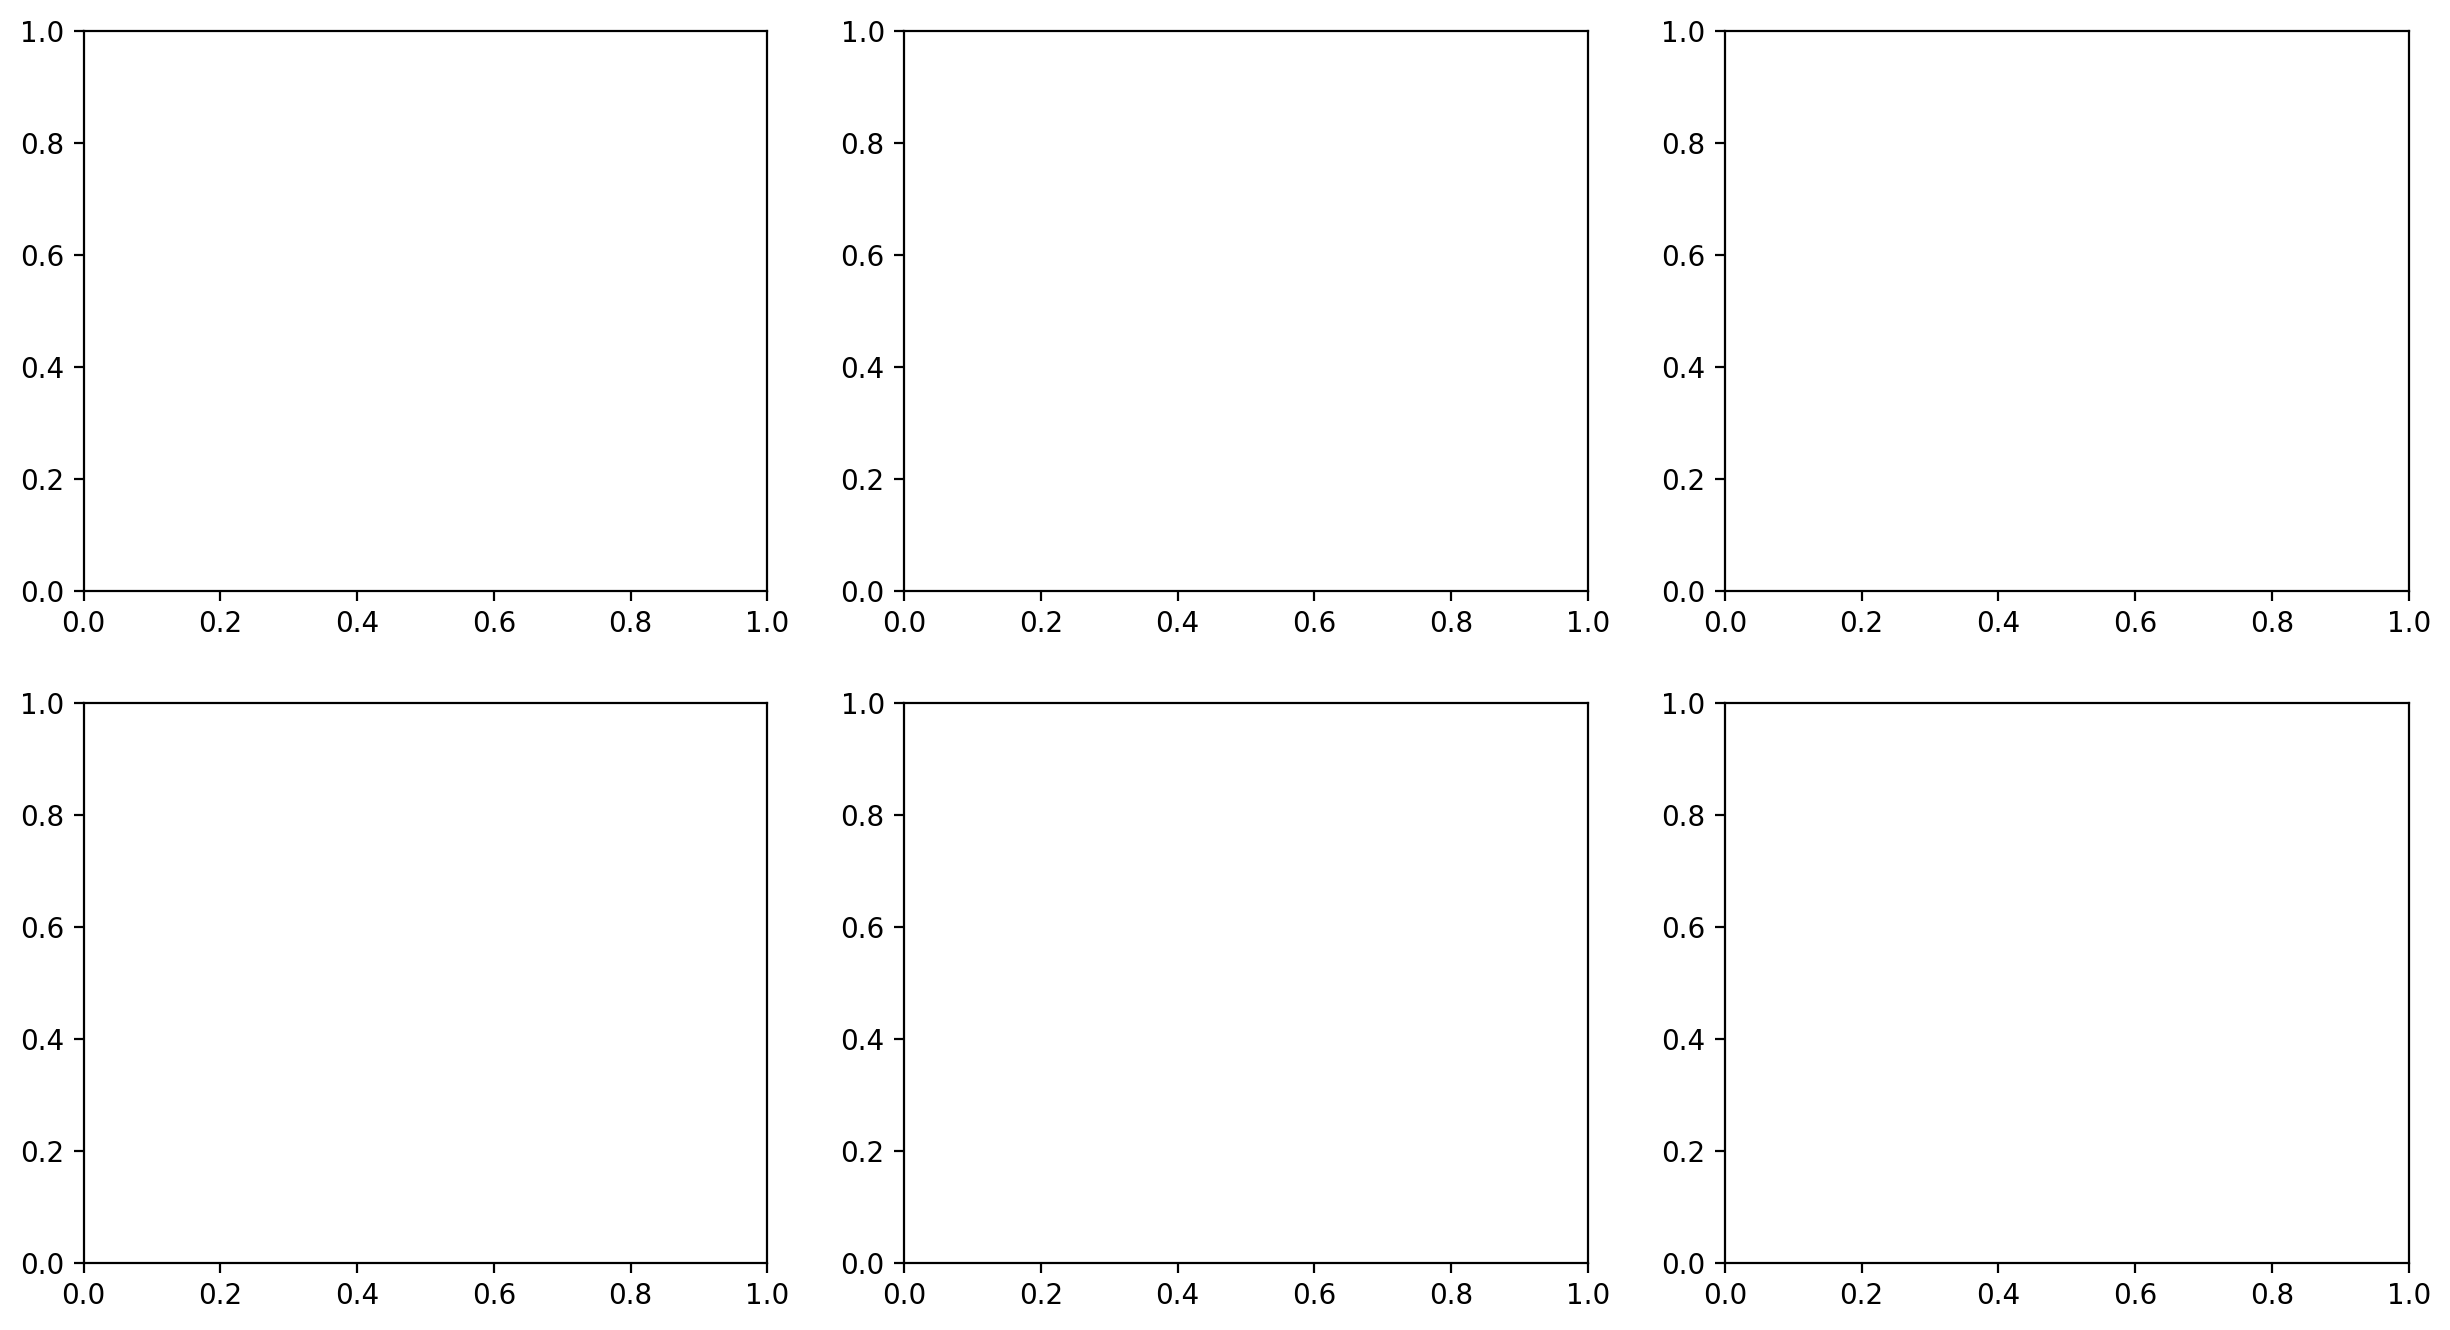

In [87]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import patches

# Start training
optimize_iters = 40
loss_history = []

plt.close('all')
fig, m_axs = plt.subplots(2, 3, figsize=(15, 8), dpi=200)

# Fit all training data
const_feed_dict = make_feed_dict(fixed_image, moving_image)

def update_frame(i):
    global loss_history
    (ax1, ax2, ax5), (ax3, ax4, ax6) = m_axs
    for c_ax in m_axs.flatten():
        c_ax.cla()
        c_ax.axis('off')
    f_ssim, x_pos, y_pos, rs_img = transform_images(const_feed_dict['FixedImage'], const_feed_dict['MovingImage'])
    loss_history += [f_ssim]

    ax1.imshow(bw_img, cmap='bone')
    ax1.set_title('$T_0$')
    ax2.imshow(shift_img, cmap='bone')
    ax2.set_title('$T_1$')
    ax3.imshow(rs_img[0, :, :, 0], cmap='bone')
    ax3.set_title('Output')
    ax4.imshow(bw_img*1.0-rs_img[0, :, :, 0],
               cmap='RdBu', vmin=-100, vmax=100)
    ax4.set_title('Difference\nSSIM: %2.2f' % (f_ssim))
    rect = patches.Rectangle(
        (25, 20), 75, 55, linewidth=2, edgecolor='g', facecolor='none')
    # Add the patch to the Axes
    ax4.add_patch(rect)
    ax5.plot(loss_history)
    ax5.set_xlabel('Iteration')
    ax5.set_ylabel('SSIM')
    ax5.axis('on')

    for _ in range(1):
        train_step(const_feed_dict['FixedImage'], const_feed_dict['MovingImage'])
# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=optimize_iters,
                          interval=1000,
                          repeat_delay=2000)

anim_code.save('movies/ssimregistration_bone.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
plt.close('all')